周辺用語復習  
・シソーラス  
単語の意味獲得において、「シソーラスによる手法」「カウントベースの手法」「推論ベースの手法」がある。  
シソーラスは人の手によって作られた類語辞書である。類語ネットワークを構築させ機械に単語を理解させる手法である。  

・コーパス 
一言でいえば「大量のテキストデータ」です。  
プログラミング的には、単語が辞書型に割り振られているものです。  

・分散表現  
色を正確に表現するにはRGBによる(201,23,30)の様なベクトルとしての記述をする様に、  
単語に対しても、「単語の意味」をベクトルとして表現したものが、分散表現です。  

・分布仮説  
単語の意味は、周囲の単語(コンテキスト)によって形成される。という仮説です。これに基づいて近年のNLPは研究が盛んです。

・共起行列  
分散表現された単語が行列状にまとめられたもの。  
カウントベースの手法では、コーパス内の各単語に対して、その単語の周辺の単語の出現頻度をカウントして集計する。

・相互情報量  
(Pointwise Mutual Information / PMI)  
平たく言ってしまえば単語が同時に出現する確率量です。
ある単語（x）単独のコーパス内での出現回数と、その周辺単語(y)（コンテキスト）との共起回数より、  
xとyの共起確率量を表しています。

・PPMI  
(Positive PMI)  
先ほどの相互情報量において、どちらも共起する回数が0の場合、計算が無限になってしまうため  
「正の相互情報量」を取り扱うことにされています。マイナスの場合は0を返す様になります。  
共起行列をPPMI行列に変換し、さらにそれを次元削減することで巨大な「疎なベクトル」を「密なベクトル」へ変換しています。  
疎なベクトルは要素のほとんどが0であることを指しています。

# word2vecとは何か？

単語の意味を獲得する手法として代表的な手法にCountベースと推論ベースがあります。  
word2vecは「推論ベースの手法」と言えます。  
カウントベースの手法がコーパス全体を用いて単語の分散表現を獲得するのに対して、  
推論ベースではその学習データの一部を取り出して逐次的に学習し、単語の意味を獲得します。  
学習にはニューラルネットワークによる重みの更新を利用したりします。  

# word2vecの二つのモデル

ニューラルネットを用いていると言いましたが、word2vecには二つのモデルが存在します  

・C-BOW(countinuous bag-of-words)  
CBOWモデルは周辺の単語（コンテキスト）から、中央の単語（ターゲット）を推論するニューラルネットワークです

・skip-gram  
対して、こちらは中央の単語（ターゲット）から周辺の単語（コンテキスト）を推論するニューラルネットワークです。

# C-BOWの計算グラフ

参考  
http://tecmemo.wpblog.jp/2017/02/25/tensorflow_mnist-example-fc-only/

# C-BOWのスクラッチ実装

「I love Tom and I love Mike.」という文章(コーパス)を利用します

## 学習データの作成

C-BOWはある予測したい単語の周辺の単語（コンテキスト）を入力，予測する単語を出力とします．  
上のコーパスの例でいうと以下のようになります．  
![代替テキスト](https://t.gyazo.com/teams/diveintocode/5e6aa2acd012c688bfb0ded3deded1bd.png)  
まずは，以下を用いてコーパスを単語IDに変換します．

In [9]:
import sys
import numpy as np
sys.path.append('..')

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


text = 'I love Tom and I love Mike.'
corpus , word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 0 1 4 5]


In [25]:
word_to_id

{'.': 5, 'and': 3, 'i': 0, 'love': 1, 'mike': 4, 'tom': 2}

以上で得られる変換後のIDを用いて，以下の関数を使うと，コンテキストとターゲットの組みが得られます．

In [0]:
def create_contexts_target(corpus, window_size=1):
    '''one-hot表現への変換を行う
    :param words: 単語IDのNumPy配列
    :param vocab_size: 語彙数
    :return: one-hot表現に変換後のNumPy配列
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

この関数で返される出力を使用して，これをone-hot表現に変換する関数を作成しましょう．  
コンテキストは（6,2,7）,ターゲットは（6,7）の形状になるはずです．  

In [0]:
contexts, target = create_contexts_target(corpus)

In [26]:
vocab_size = len(word_to_id)
contexts_onehot = np.identity(vocab_size)[contexts]
target_onehot = np.identity(vocab_size)[target]

print(contexts_onehot.shape)
print(target_onehot.shape)

(6, 2, 6)
(6, 6)


## C-BOWの実装

学習データを作成したので，モデルを実装しましょう．以下の雛形を用いてください．  
forwardメソッドでlossが返ってくるようにしましょう．

## Functions

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## レイヤークラス

In [0]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

## CBOWクラス

In [0]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f4')
        W_out = 0.01 * np.random.randn(H, V).astype('f4')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

クラスを作成したあとは，前のカリキュラムで作成したoptimaizerやtrainメソッドを使って学習をさせましょう．

## Lossの確認

上記で作成したSimpleCBOWクラスのforwardメソッドで返ってくるlossの推移を表示させてみましょう．

さらに，W_in（入力層と中間層の間の重み）を取り出して，表示してみましょう．  
うまく学習できていれば，単語の分散表現が得られているはずなので，不規則に数値が格納されているはずです（整数ではない）．



In [0]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [0]:
import time
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
#                     print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
#                           % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()
        
        
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [0]:
hidden_size = 5
batch_size = 3
max_epoch = 1000

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

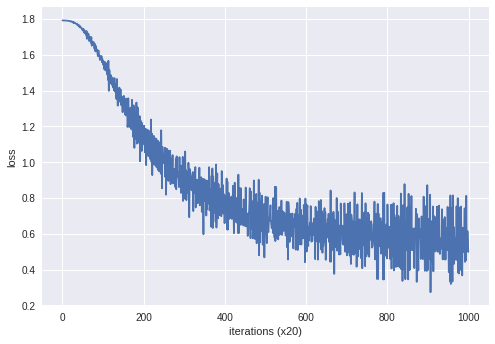

i [-0.9960109   0.999735   -1.0271883  -1.0857306   0.98355734]
love [ 1.1459461  -1.1453358   0.35959786  0.41298088 -1.1547346 ]
tom [-0.73758894  0.8047443  -0.45694837 -0.74440014  0.61200976]
and [ 0.92974734 -0.9077077  -1.87224     1.5006454  -0.937376  ]
mike [-0.99145144  0.9456089  -1.2773048  -1.1076802   1.0297072 ]
. [ 1.0336976 -1.073784   1.402409  -1.5605634 -1.0468268]


In [52]:
trainer.fit(contexts_onehot, target_onehot, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

現在は、コーパスが短すぎるため学習が安定していないと考えられます。

# skip-gramモデルの実装

参考  
https://client.diveintocode.jp/curriculums/1157

In [0]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

In [0]:
hidden_size = 5
batch_size = 3
max_epoch = 1000

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

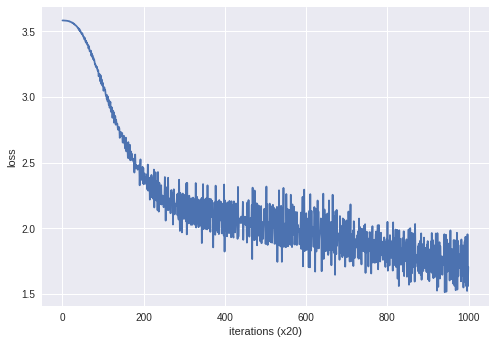

i [-0.6273765  1.1581038  0.8913783 -0.9235766  0.7950165]
love [ 0.6738512  -0.45403454 -0.4980523   0.9793064  -0.6204592 ]
tom [-0.6411484   1.1570793   0.8981767  -0.9134837   0.79369277]
and [ 0.9407123  -1.0468782  -1.0308946   0.60403246 -0.94334054]
mike [-1.3130485  -0.7160596   0.41757938 -0.27033243  0.9091492 ]
. [-0.01386213 -0.00660204  0.00606005 -0.00898436  0.01114969]


In [60]:
trainer.fit(contexts_onehot, target_onehot, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# word2vecの改良

## embeddingの説明

word2vecには課題が存在しています。  
それは巨大なコーパスを取り扱い場合に発生していしまいます。  
例えば語彙数が100万の場合、そのone-hot表現の次元も100万になります。  
よって、コンテキストと重みの計算が非常に膨大になってしますことが課題として考えられます。  

しかし、実際には行列の乗算を計算する必要はなく、重みパラメータから単語IDに該当する列(ベクトル)を抜き出すことができればニューラルネット は成り立ちます。  
この、ベクトルを抜き出すことをembeddingと言います。  

一言でまとめれば、one_hotの1の部分だけ計算すればいいよね！という発想です。

## embeddingレイヤーの実装

In [12]:
# 先に、a[...]のような三点リーダーの表現を理解。以下のような違いが起こる

import numpy as np
###############
a = np.array([1,2,3])
b = np.array([4,5,6])

a = b

a[0] = 0
print(a)
print(b)

###############
a = np.array([1,2,3])
b = np.array([4,5,6])

a[...] = b

a[0] = 0
print(a)
print(b)
# このようにメモリアドレスを固定することでインスタンス変数のgradsの扱いがよりシンプルになる。重みを共有できる。

[0 5 6]
[0 5 6]
[0 5 6]
[4 5 6]


In [0]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        w, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        dW[self.idx] = dout #　実は悪い例
        return None

このbackwardの実装には問題点があります。  
idxが重複する場合に、どちらかの値が上書きされてしまう問題が起こります  
この場合には、「代入」ではなく、「加算」を行う必要があります。  

なぜ「加算」なのでしょう。  
>
まず、このembeddingレイヤーは、入力層のMatMulレイヤーの置き換えです。  

MatMulの一部の動作を取り出しているためと考えられます  
あるいはここでの動きがp.28のRepeatノードとして考えても逆伝播は加算ということができます！

In [0]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        w, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        
    return None

## ネガティブサンプリング

まだ中間層以降に課題が残っています。  
行列の積とSftmaxレイヤの計算です。計算量が莫大です  

そこで、Negative Sampling(負例サンプリング)と呼ばれる手法を用います。  
これにより語彙数がどれだけ多くなっても計算量を少なく一定に抑えることができます。  

どのように計算を少なくするのか？  

それは解くべき問題を「多値分類」から「ニ値分類」へと変換することで実現します！  

softmaxを、sigmoidに変換します。  
他に、正例は一つですが、負例ついてはたくさん出て来てしまうため、  
絞り込む必要がありますね。まさにこれがネガティブサンプリングです。  
負例の中でも、コーパスの中で出現頻度の低いレアな単語はあまり推論において重要ではないことが言えます。  
そこで、コーパス内での出現頻度を求め、それを「確率分布」で表します。この確率分布を元に単語をサンプリングします。  
ただしそのままではなく、確率分布の各要素に0.75乗をして、レアな単語の抽出率を少しあげる調整をします。  
こうして、出現率の多かった単語から5~10程選び負例として扱い計算をさせます！  

こうすることで、計算量を少なくすることができています。
